In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
wmt = pd.read_csv('/Users/pratyush/Python/Python for Finance and Algorithmic Trading/Python-Finance-QuantConnect (1)/06-Financial-Concepts-with-Python/WMT.csv', index_col = 'Date', parse_dates = True)['Adj Close']
tgt = cost = pd.read_csv('/Users/pratyush/Python/Python for Finance and Algorithmic Trading/Python-Finance-QuantConnect (1)/06-Financial-Concepts-with-Python/TGT.csv', index_col = 'Date', parse_dates = True)['Adj Close']
dg = pd.read_csv('/Users/pratyush/Python/Python for Finance and Algorithmic Trading/Python-Finance-QuantConnect (1)/06-Financial-Concepts-with-Python/DG.csv', index_col = 'Date', parse_dates = True)['Adj Close']

In [3]:
cost = pd.read_csv('/Users/pratyush/Python/Python for Finance and Algorithmic Trading/Python-Finance-QuantConnect (1)/06-Financial-Concepts-with-Python/COST.csv', index_col = 'Date', parse_dates = True)['Adj Close']

In [6]:
retail = pd.concat([cost,wmt,tgt,dg], axis = 1)
retail.columns = ['COST','WMT','TGT','DG']

In [7]:
retail

,COST,WMT,TGT,DG
Date,,,,
2016-09-06,140.896622,65.758080,60.674061,68.342621
2016-09-07,138.739395,64.911324,60.847187,68.105331
2016-09-08,136.805038,64.704163,60.120117,67.080215
2016-09-09,134.335831,63.325943,59.721989,66.994766
2016-09-12,135.218338,64.803238,59.981625,68.366478
...,...,...,...,...
2021-08-27,450.339996,146.520004,249.179993,225.250000
2021-08-30,455.929993,147.699997,249.360001,225.360001
2021-08-31,455.489990,148.100006,246.979996,222.910004


In [17]:
def generate_weights(n):
    weights = np.random.rand(n)
    return weights / sum(weights)

def generate_mean(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

def generate_variance(weights, log_returns_covariance):
    annualized_covariance = np.dot(weights, log_returns_covariance * 252)
    variance = np.dot(weights.transpose(), annualized_covariance)
    return np.sqrt(variance)
    
log_returns = np.log(retail / retail.shift(1))
log_returns_covariance = np.log(retail / retail.shift(1)).cov()

In [18]:
mc_weights = []
mc_mean = []
mc_variance = []

for n in range(3000):
    total_weights = generate_weights(4)
    mc_weights.append(total_weights)
    
    simulated_returns = generate_mean(total_weights, log_returns)
    mc_mean.append(simulated_returns)
    
    simulated_variance = generate_variance(total_weights, log_returns_covariance)
    mc_variance.append(simulated_variance)

In [32]:
mc_sharpe_ratio = np.array(mc_mean) / np.array(mc_variance)

Text(0, 0.5, 'Returns')

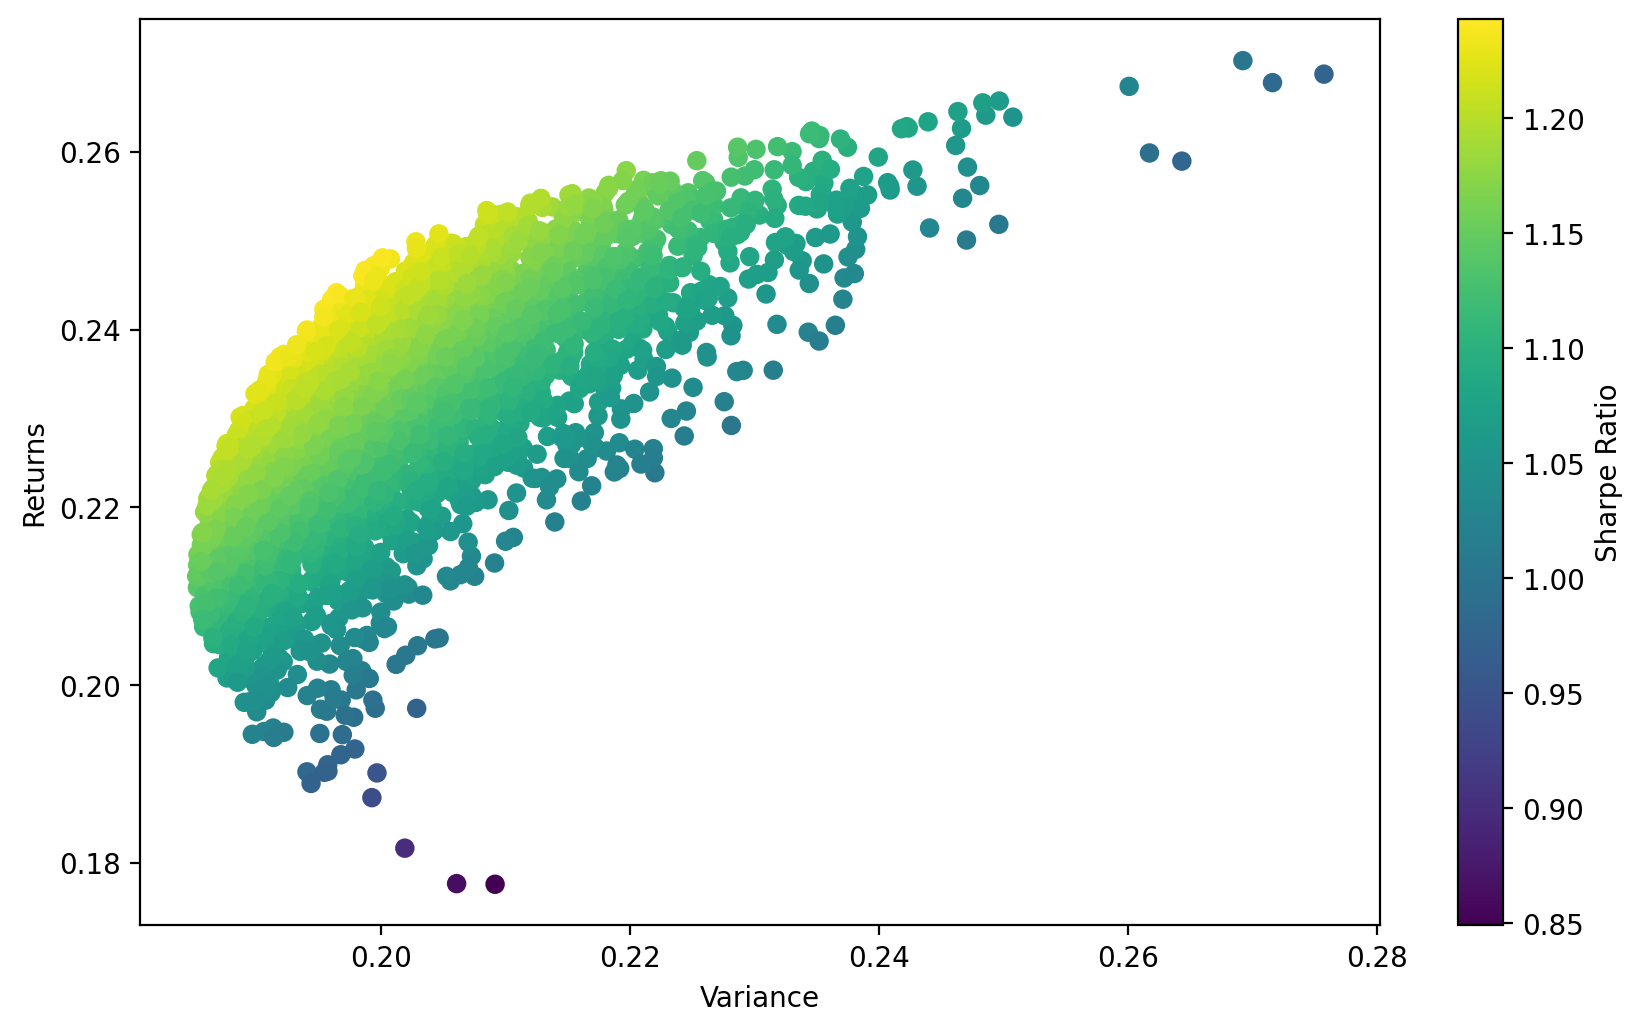

In [36]:
plt.figure(figsize = (10,6), dpi = 200)
plt.scatter(x = mc_variance, y = mc_mean, c = mc_sharpe_ratio)

plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Variance')
plt.ylabel('Returns')

In [37]:
from scipy.optimize import minimize

In [38]:
def function_to_minimize(weights):
    return -1 * (generate_mean(weights, log_returns) / generate_variance(weights, log_returns_covariance))

In [42]:
bounds = tuple((0,1) for n in range(4))
equal_weights = [0.25,0.25,0.25,0.25]
sum_constraints = ({'type':'eq','fun':lambda weights: np.sum(weights)-1})

In [43]:
minimize(fun = function_to_minimize, x0 = equal_weights, bounds = bounds, constraints = sum_constraints)

     fun: -1.2451267776201174
     jac: array([-3.51712108e-04,  5.83363473e-02,  1.11971796e-03,  3.20225954e-05])
 message: 'Optimization terminated successfully'
    nfev: 20
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([5.84568072e-01, 2.47198095e-17, 1.76790230e-01, 2.38641698e-01])

# EFFICIENT FRONTIER

In [44]:
#We will use the same minimize function to calculate the efficient frontier with one additional constraint
    #new constraint = calculation of returns - possible returns

expected_returns_range = np.linspace(0.18, 0.28, 100)

In [49]:
constraints = ({'type':'eq','fun':lambda weights: np.sum(weights)-1},
               {'type':'eq','fun':lambda weights: generate_mean(weights,log_returns)-possible_return})

In [52]:
#We are trying to minimize the volatility now

def calculate_volatility(weights):
    annualized_cov = np.dot(log_returns_covariance * 252, weights)
    volatility = np.dot(weights.transpose(), annualized_cov)
    return np.sqrt(volatility)

In [54]:
frontier_volatility = []
portfolio_holdings = []

for possible_return in expected_returns_range:
    
    result = minimize(calculate_volatility, equal_weights,bounds = bounds, constraints = constraints)
    
    
    #VOLATILITY for the RETURN
    frontier_volatility.append(result['fun'])
    portfolio_holdings.append(result['x'])

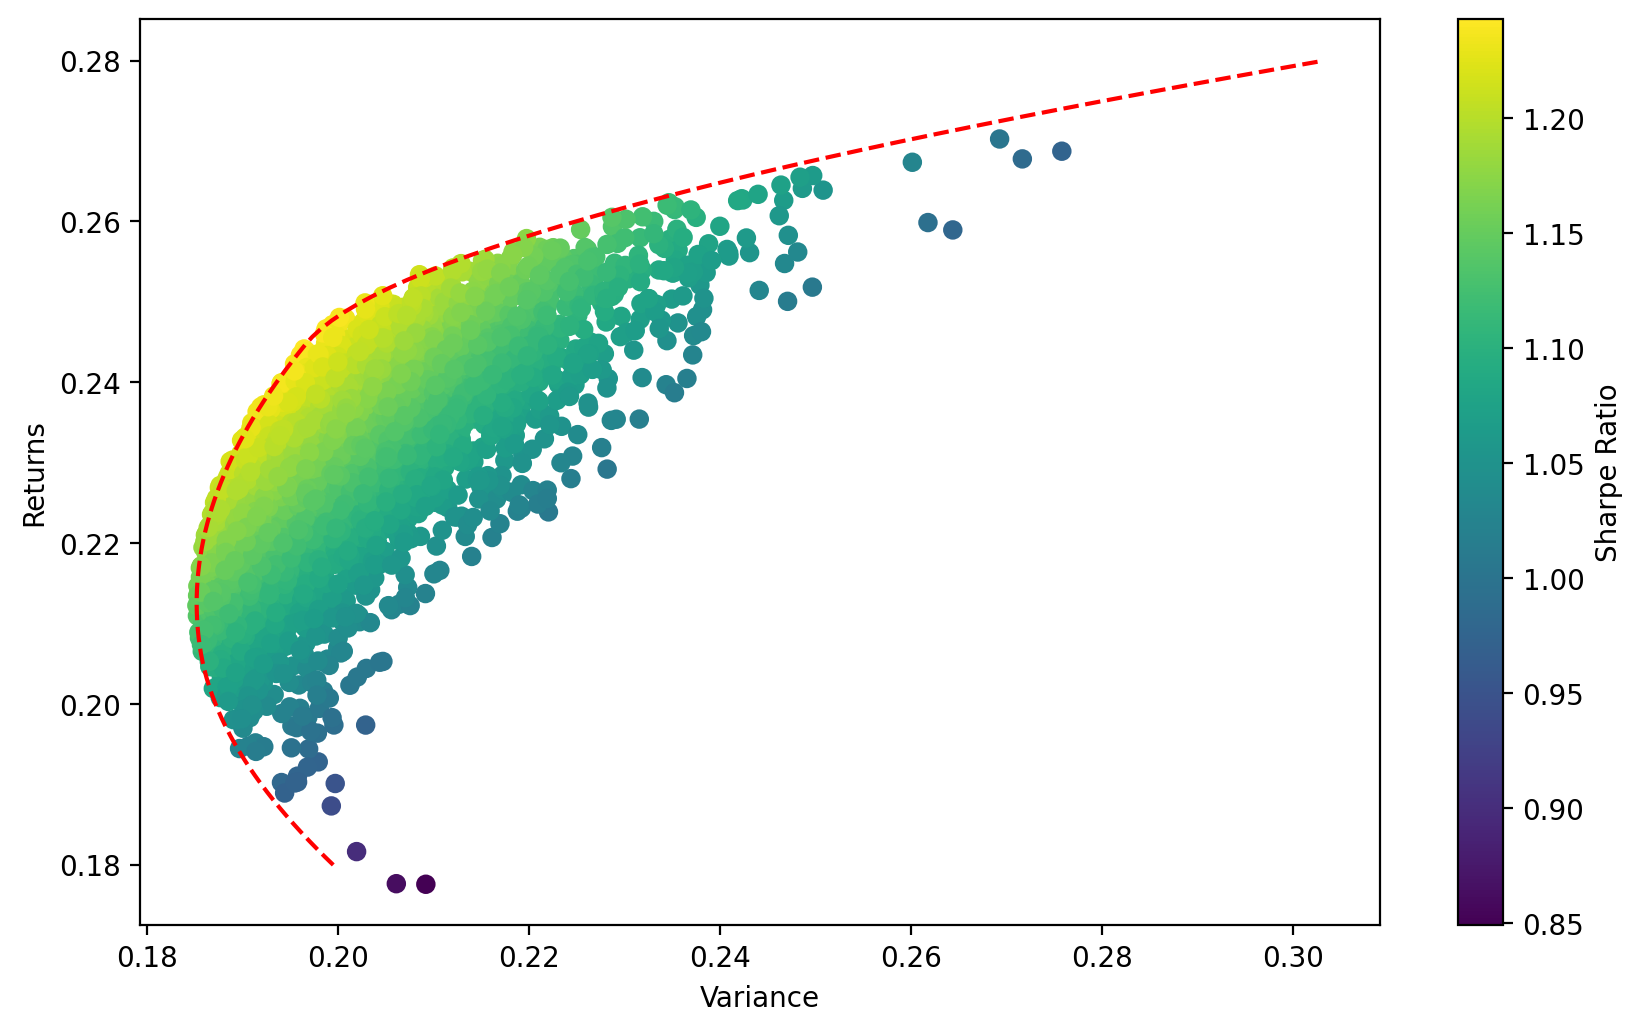

In [56]:
plt.figure(figsize = (10,6), dpi = 200)
plt.scatter(x = mc_variance, y = mc_mean, c = mc_sharpe_ratio)

plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Variance')
plt.ylabel('Returns')


plt.plot(frontier_volatility,expected_returns_range, color = 'red', ls='--')